In [3]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Krishnavamsi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Krishnavamsi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 

In [5]:
dataset = pd.read_csv('C:/Users/Krishnavamsi/Documents/Datasets/dataset/Tweets.csv')

In [6]:
dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
dataset.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

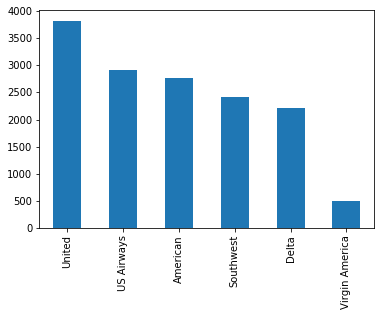

In [8]:
dataset['airline'].value_counts().plot.bar()
plt.show()

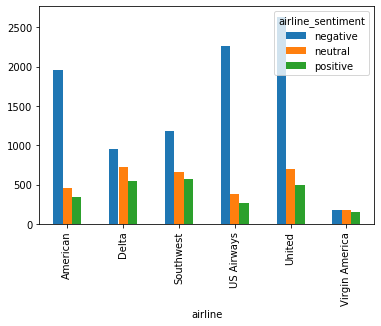

In [9]:
sentiments_X_airlines = pd.crosstab(dataset['airline'], dataset['airline_sentiment'])
sentiments_X_airlines.plot.bar()
plt.show()

In [61]:
X = dataset.iloc[:, 10].values

In [62]:
X[0]

'@VirginAmerica What @dhepburn said.'

In [63]:

def processing(tweets):
  sentiments = []
  lemmatizer = WordNetLemmatizer()
  for i in range(len(tweets)):
      temp = re.sub('^[a-zA-Z]', ' ', tweets[i])
      temp = re.sub('[^\w\s]', ' ', temp)
      temp = temp.lower()
      temp = temp.split()
      temp = [lemmatizer.lemmatize(word) for word in temp if word not in set(stopwords.words('english'))]
      temp = ' '.join(temp)
      sentiments.append(temp)
      
  return sentiments
    
sentiments = processing(X)

In [64]:
sentiments[0]

'virginamerica dhepburn said'

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(sentiments).toarray()

In [75]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
airlinename = dataset['airline'].values
lb = LabelEncoder()
ohe = OneHotEncoder(drop='first')
airlinename = lb.fit_transform(airlinename)
airlinename = ohe.fit_transform(airlinename.reshape(-1, 1)).toarray()
airlinename.shape

(14640, 5)

In [76]:
X = np.append(X, airlinename, axis = 1)

In [77]:
X.shape

(14640, 14072)

In [78]:
labels, unique = pd.factorize(dataset.iloc[:, 1])
y = np.array(labels)

In [79]:
X = X.astype(np.float32)
#y = y.astype(np.float32)

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [81]:
X_train.shape

(11712, 14072)

In [82]:
y_train.shape

(11712,)

In [24]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=42)

In [25]:
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [26]:
y_pred = classifier.predict(X_test)

In [27]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.6386612021857924

In [57]:
import tensorflow as tf 
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [89]:
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs['val_accuracy'] >= 0.79:
            self.model.stop_training = True

In [90]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [91]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
callback = Callback()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size = 100, epochs = 50, validation_data = (X_test, y_test), shuffle = True, callbacks = [callback, learning_rate_reduction])

Epoch 1/50
118/118 [==============================] - 8s 66ms/step - loss: 0.6838 - accuracy: 0.7058 - val_loss: 0.5157 - val_accuracy: 0.7971 - lr: 0.0010
